In [2]:
from FeatureEngineering import load_game_data, build_model_dataframe
import sys
import os

# Add project root to path for generic imports (Jupyter notebook version)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from generic.db import get_engine

# Team batting stats (match view: homeHits -> 'Hits')
TEAM_BATTING_STATS = [
    "Runs", "Hits", "Doubles", "Triples", "HomeRuns",
    "RBI", "Walks", "Strikeouts", "StolenBases", "LOB",
    "BA", "OBP", "SLG", "OPS",
]

# Team pitching stats (match view: homeEarnedRuns -> 'EarnedRuns')
TEAM_PITCHING_STATS = [
    "EarnedRuns", "HitsAllowed", "HRAllowed",
    "WalksAllowed", "StrikeoutsPitched", "ERA",
]

TEAM_STATS = TEAM_BATTING_STATS + TEAM_PITCHING_STATS
WINDOWS = [5]

# Load and build features
engine = get_engine('MLB')
game_df = load_game_data(engine)

model_df = build_model_dataframe(
    game_df=game_df,
    team_stats=TEAM_STATS,
    windows=WINDOWS,
)

Starting feature engineering pipeline...
Initial dataset: 12121 games
Building team rolling features for 20 stats, windows=[5]...
Creating differential features...
Adding market features...
Adding target variables...
Selecting final columns...
Feature engineering complete!
Final dataset: 12121 games, 50 features


In [4]:
# -----------------------------
# DEFINE TARGET AND FEATURES
# -----------------------------
TARGET_COLUMN = "homeWin"
RANDOM_SEED = 42

model_df = model_df[model_df[TARGET_COLUMN].notna()]

# Differential features (rolling stats: home - away)
DIFF_FEATURES = [col for col in model_df.columns if "_diff_l" in col]

# Market features
MARKET_FEATURES = [
    "homeImpliedProb", "awayImpliedProb", "favoriteDegree", "impliedProbDiff",
    "line_percentile", "line_vs_avg", "spreadMagnitude",
]

# Combine all features (filter to those that exist)
FEATURES = [f for f in DIFF_FEATURES if f in model_df.columns]

print(f"Target: {TARGET_COLUMN}")
print(f"Features ({len(FEATURES)}):")
for f in FEATURES:
    print(f"  {f}")
    
# -----------------------------
# PREPARE DATA
# -----------------------------
# Drop rows with missing target, features, or gameDate
clean_df = model_df.dropna(subset=[TARGET_COLUMN, "gameDate"] + FEATURES).copy()
clean_df[TARGET_COLUMN] = clean_df[TARGET_COLUMN].astype(int)
clean_df = clean_df.sort_values("gameDate").reset_index(drop=True)

train_df = clean_df.copy()

print(f"Train: {len(train_df)} games ({train_df['gameDate'].min()} to {train_df['gameDate'].max()})")

Target: homeWin
Features (20):
  ba_diff_l5
  doubles_diff_l5
  earnedruns_diff_l5
  era_diff_l5
  hits_diff_l5
  hitsallowed_diff_l5
  homeruns_diff_l5
  hrallowed_diff_l5
  lob_diff_l5
  obp_diff_l5
  ops_diff_l5
  rbi_diff_l5
  runs_diff_l5
  slg_diff_l5
  stolenbases_diff_l5
  strikeouts_diff_l5
  strikeoutspitched_diff_l5
  triples_diff_l5
  walks_diff_l5
  walksallowed_diff_l5
Train: 11723 games (2021-04-06 00:00:00 to 2025-11-01 00:00:00)


In [5]:
from generic.pipeline_code.DataPreprocessor import DataPreprocessor
from generic.pipeline_code.mainMLM import run_ml_pipeline

# -----------------------------
# TRAIN MODEL
# -----------------------------
preprocessor = DataPreprocessor()

train_df = train_df[FEATURES + ["gameDate", TARGET_COLUMN]]

model = run_ml_pipeline(
    df=train_df,
    target_column=TARGET_COLUMN,
    preprocessor=preprocessor,
    model_type="xgb",
    random_seed=RANDOM_SEED,
    metric="precision",
    n_trials=5,
    test_size=0.20,
    show_plots=False,
    split_type="time",
    time_col="gameDate",
)

/Users/tommylife/sports-analytics/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== Training XGBoost Model ===

Problem type: CLASSIFICATION
Split type used: time
Train rows: 9378
Test rows: 2345

Optimizing hyperparameters...
Optimizing for metric: precision
Optimization direction: maximize
Pruning enabled: True
✅ Trial #0 completed
✅ Trial #1 completed
✅ Trial #2 completed
✅ Trial #3 completed
✅ Trial #4 completed

Best parameters found: {'n_estimators': 186, 'max_depth': 2, 'learning_rate': 0.02677113724214592, 'subsample': 0.5418481581956126, 'colsample_bytree': 0.5876433945605655, 'min_child_weight': 7, 'gamma': 1.1841049763255538, 'reg_alpha': 1.6777639420895203, 'reg_lambda': 1.3993475643167195}

=== Model Performance ===

Class Distribution:
Class 0: 5488 samples (46.8%)
Class 1: 6235 samples (53.2%)

Training Metrics:
Accuracy: 0.5835
Precision: 0.5817
Recall: 0.5835
F1: 0.5765
Auc: 0.5758

Test Metrics:
Accuracy: 0.5480
Precision: 0.5423
Recall: 0.5480
F1: 0.5389
Auc: 0.5371

Top 5 Most Important Features:
              feature  weight  gain percent
0  

In [7]:
from Backtest import optimize_threshold_range, backtest_betting_strategy
from generic.pipeline_code.PickleModels import load_model
from sklearn.model_selection import train_test_split

# -----------------------------
# EVALUATION
# -----------------------------

# Get test data with predictions
test_df = model.X_test.copy()
test_df["actual"] = model.y_test.values
test_df["pred"]   = model.y_test_pred
test_df["proba"]  = model.y_test_proba

# Get the test indices to find the original game data
test_indices = model.X_test.index  # These are the indices in clean_df

# Get the corresponding games from clean_df (which has gameId)
test_games = clean_df.loc[test_indices, ["gameId", "homeMoneyline", "awayMoneyline"]].copy()

# Add odds to test_df using the indices
test_df["gameId"] = test_games["gameId"].values
test_df["homeMoneyline"] = test_games["homeMoneyline"].values
test_df["awayMoneyline"] = test_games["awayMoneyline"].values

# Verify we have the odds columns
print(f"test_df shape: {test_df.shape}")
print(f"Columns with odds: {[c for c in test_df.columns if 'moneyline' in c or 'gameId' in c]}")

# -----------------------------
# SPLIT TEST SET: Optimization (50%) vs Evaluation (50%)
# -----------------------------
opt_df, eval_df = train_test_split(test_df, test_size=0.5, random_state=42)

min_bets = len(opt_df) * 0.25

print(f"\nOptimization set size: {len(opt_df)}")
print(f"Evaluation set size: {len(eval_df)}")

# -----------------------------
# OPTIMIZE THRESHOLDS on optimization set
# -----------------------------
optimization_results = optimize_threshold_range(
    opt_df,
    lower_range=(0.0, 0.5),
    upper_range=(0.5, 1.0),
    step=0.01,
    stake=1.0,
    min_bets=min_bets,
    optimize_metric="roi_per_bet",
    home_odds_col="homeMoneyline",
    away_odds_col="awayMoneyline"
)

# Get the best configuration
best = optimization_results['best_config']

print(f"\n--- Optimization Results (on optimization set) ---")
print(f"Lower Threshold: {100*best['lower_threshold']:.1f}%")
print(f"Upper Threshold: {100*best['upper_threshold']:.1f}%")
print(f"Total Bets: {best['bets']:.0f}")
print(f"Win rate: {100 * best['win_rate']:.2f}%")
print(f"Units: {best['total_units']:.2f}")
print(f"ROI Per Bet: {best['roi_per_bet']:.4f}")

# -----------------------------
# EVALUATE on held-out evaluation set
# -----------------------------
summary, bets = backtest_betting_strategy(
    eval_df,
    lower_threshold=best['lower_threshold'],
    upper_threshold=best['upper_threshold'],
    stake=1.0,
    home_odds_col="homeMoneyline",
    away_odds_col="awayMoneyline"
)

print(f"\n--- Final Evaluation (on held-out evaluation set) ---")
print(f"Lower Threshold: {100*best['lower_threshold']:.1f}%")
print(f"Upper Threshold: {100*best['upper_threshold']:.1f}%")
print(f"\nTotal Bets: {summary['bets']}")
print(f"Win rate: {100 * summary['win_rate']:.2f}%")
print(f"Units: {summary['total_units']:.2f}")
print(f"ROI Per Bet: {summary['roi_per_bet']:.4f}")
print(f"Sharpe Ratio: {summary['sharpe']:.4f}")
print(f"Max Drawdown: {summary['max_drawdown']:.2f}")


test_df shape: (2345, 26)
Columns with odds: ['gameId']

Optimization set size: 1172
Evaluation set size: 1173

--- Optimization Results (on optimization set) ---
Lower Threshold: 48.0%
Upper Threshold: 64.0%
Total Bets: 322
Win rate: 55.59%
Units: 57.46
ROI Per Bet: 0.1784

--- Final Evaluation (on held-out evaluation set) ---
Lower Threshold: 48.0%
Upper Threshold: 64.0%

Total Bets: 369
Win rate: 56.64%
Units: 66.41
ROI Per Bet: 0.1800
Sharpe Ratio: 0.1644
Max Drawdown: -11.82


In [8]:
# =====================================================
# DETAILED RESULTS ANALYSIS (on held-out evaluation set)
# =====================================================

print("=" * 70)
print("THRESHOLD OPTIMIZATION & BACKTEST ANALYSIS")
print("=" * 70)

# 1. THRESHOLD ANALYSIS
print("\n1️⃣  THRESHOLD STRATEGY")
print("-" * 70)
print(f"   Lower Threshold: {100*best['lower_threshold']:.1f}% (BET AWAY when model ≤ {100*best['lower_threshold']:.1f}%)")
print(f"   Upper Threshold: {100*best['upper_threshold']:.1f}% (BET HOME when model ≥ {100*best['upper_threshold']:.1f}%)")
print(f"   NO BET ZONE: {100*best['lower_threshold']:.1f}% - {100*best['upper_threshold']:.1f}% (model uncertain)")
print(f"   → Thresholds optimized on {len(opt_df)} games, evaluated on {len(eval_df)} held-out games")

# 2. BET FREQUENCY
print("\n2️⃣  BET FREQUENCY & SELECTIVITY")
print("-" * 70)
total_games_eval = len(eval_df)
bets_placed = summary['bets']
bet_percentage = (bets_placed / total_games_eval) * 100
pass_percentage = ((total_games_eval - bets_placed) / total_games_eval) * 100

print(f"   Total games in evaluation set: {total_games_eval}")
print(f"   Bets placed: {bets_placed} ({bet_percentage:.1f}%)")
print(f"   Games passed (no bet): {total_games_eval - bets_placed} ({pass_percentage:.1f}%)")

# 3. PREDICTION ACCURACY
print("\n3️⃣  PREDICTION ACCURACY (Classification Metrics)")
print("-" * 70)
away_bets = bets[bets['bet_side'] == 0]
home_bets = bets[bets['bet_side'] == 1]
away_correct = away_bets['win'].sum()
home_correct = home_bets['win'].sum()

print(f"   Away Win (Class 0):")
print(f"      • Correct: {away_correct} out of {len(away_bets)} ({(away_correct/len(away_bets))*100:.1f}%)" if len(away_bets) > 0 else "      • No away bets")
print(f"   ")
print(f"   Home Win (Class 1):")
print(f"      • Correct: {home_correct} out of {len(home_bets)} ({(home_correct/len(home_bets))*100:.1f}%)" if len(home_bets) > 0 else "      • No home bets")
print(f"   ")
print(f"   Overall Accuracy: {summary['win_rate']*100:.1f}%")

# 4. BETTING PERFORMANCE
print("\n4️⃣  BETTING PERFORMANCE (Financial Metrics)")
print("-" * 70)
win_count = bets['win'].sum()
loss_count = len(bets) - win_count

print(f"   Win Rate: {summary['win_rate']*100:.2f}% ({win_count} wins, {loss_count} losses)")
print(f"   Total Units Profit: {summary['total_units']:.2f}")
print(f"   ROI Per Bet: {summary['roi_per_bet']:.4f} ({summary['roi_per_bet']*100:.2f}% return per $1 bet)")
print(f"   ")
print(f"   Interpretation:")
print(f"   • If betting $100 per game: ${summary['total_units'] * 100:.0f} profit on {bets_placed} bets")
print(f"   • Average win: {bets[bets['win']==1]['units'].mean():.2f} units")
print(f"   • Average loss: {bets[bets['win']==0]['units'].mean():.2f} units")

# 5. RISK METRICS
print("\n5️⃣  RISK MANAGEMENT")
print("-" * 70)
print(f"   Sharpe Ratio: {summary['sharpe']:.4f}")
print(f"   Max Drawdown: {summary['max_drawdown']:.2f} units")

# 6. OPTIMIZATION vs EVALUATION COMPARISON
print("\n6️⃣  OPTIMIZATION vs EVALUATION COMPARISON")
print("-" * 70)
print(f"   {'Metric':<20} {'Optimization':<15} {'Evaluation':<15} {'Diff':<10}")
print(f"   {'-'*60}")
print(f"   {'Bets':<20} {best['bets']:<15.0f} {summary['bets']:<15} {summary['bets'] - best['bets']:<10.0f}")
print(f"   {'Win Rate':<20} {best['win_rate']*100:<15.2f}% {summary['win_rate']*100:<14.2f}% {(summary['win_rate'] - best['win_rate'])*100:<10.2f}%")
print(f"   {'ROI Per Bet':<20} {best['roi_per_bet']:<15.4f} {summary['roi_per_bet']:<15.4f} {summary['roi_per_bet'] - best['roi_per_bet']:<10.4f}")
print(f"   {'Sharpe':<20} {best['sharpe']:<15.4f} {summary['sharpe']:<15.4f} {summary['sharpe'] - best['sharpe']:<10.4f}")

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

# Dynamic summary based on results
roi_diff = summary['roi_per_bet'] - best['roi_per_bet']
if roi_diff >= -0.05:
    print(f"\n✓ Model generalizes well: evaluation ROI ({summary['roi_per_bet']:.4f}) close to optimization ({best['roi_per_bet']:.4f})")
else:
    print(f"\n⚠ Possible overfitting: evaluation ROI ({summary['roi_per_bet']:.4f}) lower than optimization ({best['roi_per_bet']:.4f})")

if summary['roi_per_bet'] > 0:
    print(f"✓ Positive edge on held-out data: {summary['roi_per_bet']*100:.2f}% ROI")
else:
    print(f"✗ Negative ROI on held-out data: {summary['roi_per_bet']*100:.2f}%")

print("=" * 70)

THRESHOLD OPTIMIZATION & BACKTEST ANALYSIS

1️⃣  THRESHOLD STRATEGY
----------------------------------------------------------------------
   Lower Threshold: 48.0% (BET AWAY when model ≤ 48.0%)
   Upper Threshold: 64.0% (BET HOME when model ≥ 64.0%)
   NO BET ZONE: 48.0% - 64.0% (model uncertain)
   → Thresholds optimized on 1172 games, evaluated on 1173 held-out games

2️⃣  BET FREQUENCY & SELECTIVITY
----------------------------------------------------------------------
   Total games in evaluation set: 1173
   Bets placed: 369 (31.5%)
   Games passed (no bet): 804 (68.5%)

3️⃣  PREDICTION ACCURACY (Classification Metrics)
----------------------------------------------------------------------
   Away Win (Class 0):
      • Correct: 154 out of 287 (53.7%)
   
   Home Win (Class 1):
      • Correct: 55 out of 82 (67.1%)
   
   Overall Accuracy: 56.6%

4️⃣  BETTING PERFORMANCE (Financial Metrics)
----------------------------------------------------------------------
   Win Rate: 56.64%

Rows with homeMoneyline == 0: 2
Rows with awayMoneyline == 0: 2
Rows with null homeMoneyline: 0
Rows with null awayMoneyline: 0

After filtering: 2343 rows

Bets: 315, Win Rate: 54.9%, ROI: 0.1415, Units: 44.58


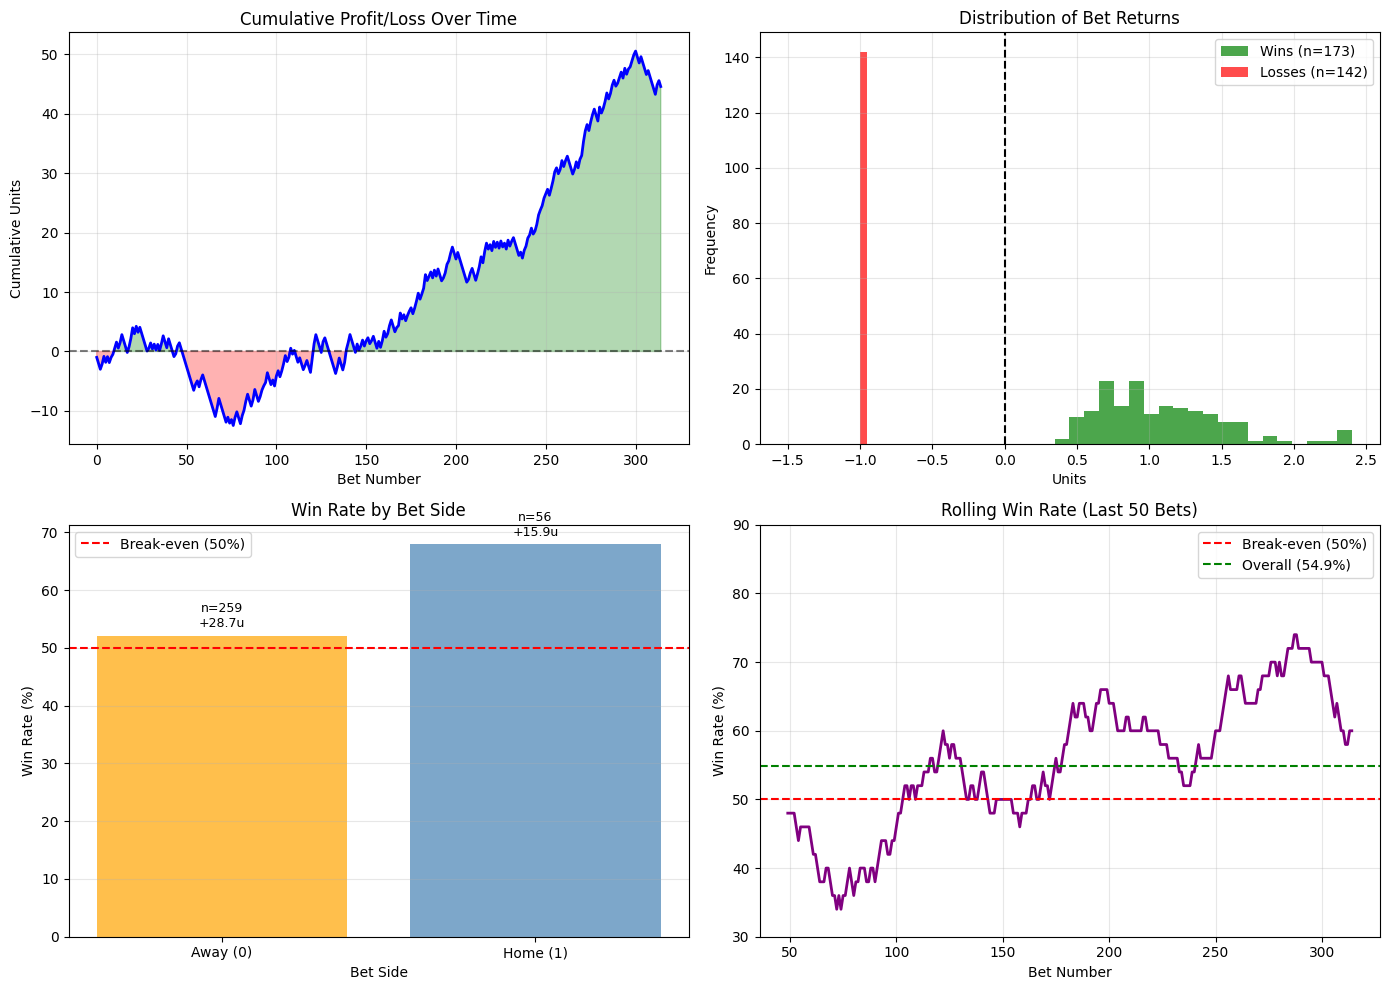


=== Backtest Summary ===
Total Bets: 315
Wins: 173 (54.9%)
Total Units: 44.58
Avg Win: 1.08 units
Avg Loss: -1.00 units
Max Drawdown: -16.69 units
Peak Units: 50.55 units


In [9]:
import matplotlib.pyplot as plt

# Get the bets dataframe from the original evaluation
test_df = model.X_test.copy()
test_df["actual"] = model.y_test.values
test_df["pred"] = model.y_test_pred
test_df["proba"] = model.y_test_proba

# Get odds - match by position since we know the time-based ordering
clean_complete = clean_df.dropna(subset=FEATURES + [TARGET_COLUMN]).sort_values('gameDate').reset_index(drop=True)
split_idx = int(len(clean_complete) * 0.75)
test_portion = clean_complete.iloc[split_idx:split_idx + len(model.X_test)].reset_index(drop=True)

test_df["homeMoneyline"] = test_portion["homeMoneyline"].values
test_df["awayMoneyline"] = test_portion["awayMoneyline"].values
test_df["gameDate"] = test_portion["gameDate"].values

# Check for invalid odds
print(f"Rows with homeMoneyline == 0: {(test_df['homeMoneyline'] == 0).sum()}")
print(f"Rows with awayMoneyline == 0: {(test_df['awayMoneyline'] == 0).sum()}")
print(f"Rows with null homeMoneyline: {test_df['homeMoneyline'].isna().sum()}")
print(f"Rows with null awayMoneyline: {test_df['awayMoneyline'].isna().sum()}")

# Filter out invalid odds
test_df = test_df[(test_df['homeMoneyline'] != 0) & (test_df['awayMoneyline'] != 0)].copy()
test_df = test_df.dropna(subset=['homeMoneyline', 'awayMoneyline']).copy()

print(f"\nAfter filtering: {len(test_df)} rows")

# Split into opt/eval
half = len(test_df) // 2
eval_df = test_df.iloc[half:].copy()

# Run backtest with original thresholds
summary, bets = backtest_betting_strategy(
    eval_df,
    lower_threshold=best['lower_threshold'],
    upper_threshold=best['upper_threshold'],
    stake=1.0,
    home_odds_col="homeMoneyline",
    away_odds_col="awayMoneyline"
)

if summary is None:
    print("Not enough bets")
else:
    print(f"\nBets: {summary['bets']}, Win Rate: {summary['win_rate']*100:.1f}%, ROI: {summary['roi_per_bet']:.4f}, Units: {summary['total_units']:.2f}")

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Cumulative Units Over Time
    ax1 = axes[0, 0]
    ax1.plot(bets['cum_units'].values, linewidth=2, color='blue')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.fill_between(range(len(bets)), 0, bets['cum_units'].values, 
                      where=(bets['cum_units'].values >= 0), alpha=0.3, color='green')
    ax1.fill_between(range(len(bets)), 0, bets['cum_units'].values, 
                      where=(bets['cum_units'].values < 0), alpha=0.3, color='red')
    ax1.set_xlabel('Bet Number')
    ax1.set_ylabel('Cumulative Units')
    ax1.set_title('Cumulative Profit/Loss Over Time')
    ax1.grid(True, alpha=0.3)

    # 2. Distribution of Bet Returns
    ax2 = axes[0, 1]
    wins = bets[bets['win'] == 1]['units']
    losses = bets[bets['win'] == 0]['units']
    ax2.hist(wins, bins=20, alpha=0.7, label=f'Wins (n={len(wins)})', color='green')
    ax2.hist(losses, bins=20, alpha=0.7, label=f'Losses (n={len(losses)})', color='red')
    ax2.axvline(x=0, color='black', linestyle='--')
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Bet Returns')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Win Rate by Bet Side (Home vs Away)
    ax3 = axes[1, 0]
    side_stats = bets.groupby('bet_side').agg({
        'win': ['mean', 'count'],
        'units': 'sum'
    }).round(3)
    side_stats.columns = ['win_rate', 'count', 'total_units']

    x_labels = ['Away (0)', 'Home (1)']
    x_pos = [0, 1]
    colors = ['orange', 'steelblue']
    bars = ax3.bar(x_pos, side_stats['win_rate'] * 100, color=colors, alpha=0.7)
    ax3.axhline(y=50, color='red', linestyle='--', label='Break-even (50%)')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(x_labels)
    ax3.set_xlabel('Bet Side')
    ax3.set_ylabel('Win Rate (%)')
    ax3.set_title('Win Rate by Bet Side')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # Add count labels on bars
    for i, bar in enumerate(bars):
        count = side_stats['count'].iloc[i]
        units = side_stats['total_units'].iloc[i]
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'n={int(count)}\n{units:+.1f}u', ha='center', va='bottom', fontsize=9)

    # 4. Rolling Win Rate (last 50 bets)
    ax4 = axes[1, 1]
    rolling_window = min(50, len(bets) // 3)
    if rolling_window >= 10:
        bets['rolling_win_rate'] = bets['win'].rolling(window=rolling_window, min_periods=rolling_window).mean()
        ax4.plot(bets['rolling_win_rate'].values * 100, linewidth=2, color='purple')
        ax4.axhline(y=50, color='red', linestyle='--', label='Break-even (50%)')
        ax4.axhline(y=bets['win'].mean() * 100, color='green', linestyle='--', label=f'Overall ({bets["win"].mean()*100:.1f}%)')
        ax4.set_xlabel('Bet Number')
        ax4.set_ylabel('Win Rate (%)')
        ax4.set_title(f'Rolling Win Rate (Last {rolling_window} Bets)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(30, 90)
    else:
        ax4.text(0.5, 0.5, 'Not enough bets for rolling analysis', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Rolling Win Rate')

    plt.tight_layout()
    plt.show()

    # Print summary stats
    print(f"\n=== Backtest Summary ===")
    print(f"Total Bets: {len(bets)}")
    print(f"Wins: {int(bets['win'].sum())} ({bets['win'].mean()*100:.1f}%)")
    print(f"Total Units: {bets['units'].sum():.2f}")
    print(f"Avg Win: {wins.mean():.2f} units")
    print(f"Avg Loss: {losses.mean():.2f} units")
    print(f"Max Drawdown: {(bets['cum_units'] - bets['cum_units'].cummax()).min():.2f} units")
    print(f"Peak Units: {bets['cum_units'].max():.2f} units")

In [11]:
# -----------------------------
# HOLDOUT VALIDATION: Train through Aug 2025, Test Sep-Nov 2025
# -----------------------------
from generic.pipeline_code.DataPreprocessor import DataPreprocessor
from generic.pipeline_code.XGBoostModel import XGBoostModel
from Backtest import optimize_threshold_range, backtest_betting_strategy

# Filter data
holdout_cutoff = '2025-07-01'

# Training data: everything before Sep 2025
train_data = clean_df[clean_df['gameDate'] < holdout_cutoff].copy()

# Holdout data: Sep-Nov 2025 (completely untouched)
holdout_data = clean_df[clean_df['gameDate'] >= holdout_cutoff].copy()

print(f"Training data: {train_data['gameDate'].min()} to {train_data['gameDate'].max()} ({len(train_data)} games)")
print(f"Holdout data: {holdout_data['gameDate'].min()} to {holdout_data['gameDate'].max()} ({len(holdout_data)} games)")

# Train model on training data only
preprocessor = DataPreprocessor()
holdout_model = XGBoostModel(
    df=train_data[FEATURES + ["gameDate", TARGET_COLUMN]],
    target_column=TARGET_COLUMN,
    preprocessor=preprocessor
)

holdout_model.train_model(
    random_state=RANDOM_SEED,
    metric="precision",
    n_trials=10,
    test_size=0.25,
    split_type="time",
    time_col="gameDate"
)

# Get thresholds from the model's internal test set (NOT holdout)
# This simulates optimizing thresholds before deployment
internal_test = holdout_model.X_test.copy()
internal_test['actual'] = holdout_model.y_test.values
internal_test['proba'] = holdout_model.y_test_proba

# Match odds from train_data for internal test
train_sorted = train_data.sort_values('gameDate').reset_index(drop=True)
split_idx = int(len(train_sorted) * 0.75)
internal_test_portion = train_sorted.iloc[split_idx:split_idx + len(internal_test)].reset_index(drop=True)
internal_test['homeMoneyline'] = internal_test_portion['homeMoneyline'].values
internal_test['awayMoneyline'] = internal_test_portion['awayMoneyline'].values

# Filter out invalid odds
internal_test = internal_test[(internal_test['homeMoneyline'] != 0) & (internal_test['awayMoneyline'] != 0)].copy()

# Optimize thresholds on internal test set
opt_results = optimize_threshold_range(
    internal_test,
    lower_range=(0.0, 0.5),
    upper_range=(0.5, 1.0),
    step=0.01,
    stake=1.0,
    min_bets=100,
    optimize_metric="roi_per_bet",
    home_odds_col="homeMoneyline",
    away_odds_col="awayMoneyline"
)

best = opt_results['best_config']
print(f"\nOptimized thresholds: {best['lower_threshold']:.3f} / {best['upper_threshold']:.3f}")
print(f"Internal test ROI: {best['roi_per_bet']:.4f}")

# -----------------------------
# NOW TEST ON HOLDOUT (the "paper trade")
# -----------------------------
print("\n" + "="*70)
print("HOLDOUT VALIDATION (Sep-Nov 2025) - Simulated Paper Trade")
print("="*70)

# Prepare holdout data
X_holdout = holdout_data[FEATURES].copy()
X_holdout = preprocessor.transform_data(X_holdout)

holdout_test = X_holdout.copy()
holdout_test['actual'] = holdout_data[TARGET_COLUMN].values
holdout_test['proba'] = holdout_model.model.predict_proba(X_holdout)[:, 1]
holdout_test['homeMoneyline'] = holdout_data['homeMoneyline'].values
holdout_test['awayMoneyline'] = holdout_data['awayMoneyline'].values
holdout_test['gameDate'] = holdout_data['gameDate'].values

# Filter invalid odds
holdout_test = holdout_test[(holdout_test['homeMoneyline'] != 0) & (holdout_test['awayMoneyline'] != 0)].copy()

print(f"\nHoldout games with valid odds: {len(holdout_test)}")

# Run backtest with optimized thresholds
summary, bets = backtest_betting_strategy(
    holdout_test,
    lower_threshold=best['lower_threshold'],
    upper_threshold=best['upper_threshold'],
    stake=1.0,
    home_odds_col="homeMoneyline",
    away_odds_col="awayMoneyline"
)

if summary:
    print(f"\n--- HOLDOUT RESULTS ---")
    print(f"Thresholds: {best['lower_threshold']:.2f} / {best['upper_threshold']:.2f}")
    print(f"Total Bets: {summary['bets']}")
    print(f"Win Rate: {summary['win_rate']*100:.2f}%")
    print(f"Total Units: {summary['total_units']:.2f}")
    print(f"ROI Per Bet: {summary['roi_per_bet']:.4f} ({summary['roi_per_bet']*100:.2f}%)")
    print(f"Sharpe Ratio: {summary['sharpe']:.4f}")
    print(f"Max Drawdown: {summary['max_drawdown']:.2f}")
    
    # Verdict
    print(f"\n--- VERDICT ---")
    if summary['roi_per_bet'] > 0.05:
        print(f"✓ STRONG: Holdout ROI of {summary['roi_per_bet']*100:.1f}% suggests real edge")
    elif summary['roi_per_bet'] > 0:
        print(f"~ MARGINAL: Holdout ROI of {summary['roi_per_bet']*100:.1f}% - edge may exist but is small")
    else:
        print(f"✗ NEGATIVE: Holdout ROI of {summary['roi_per_bet']*100:.1f}% - model not profitable on new data")
else:
    print("Not enough bets in holdout period")

Training data: 2021-04-06 00:00:00 to 2025-06-30 00:00:00 (10516 games)
Holdout data: 2025-07-01 00:00:00 to 2025-11-01 00:00:00 (1207 games)

Problem type: CLASSIFICATION
Split type used: time
Train rows: 7887
Test rows: 2629

Optimizing hyperparameters...
Optimizing for metric: precision
Optimization direction: maximize
Pruning enabled: True
✅ Trial #0 completed
✅ Trial #1 completed
✅ Trial #2 completed
✅ Trial #3 completed
✅ Trial #4 completed
✅ Trial #5 completed
✅ Trial #6 completed
✅ Trial #7 completed
✅ Trial #8 completed
✅ Trial #9 completed

Best parameters found: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.010776244716748864, 'subsample': 0.6822634555704316, 'colsample_bytree': 0.5511572371061875, 'min_child_weight': 5, 'gamma': 1.92332830588, 'reg_alpha': 1.948448049611839, 'reg_lambda': 2.6167946962329225}

Optimized thresholds: 0.440 / 0.680
Internal test ROI: 0.0634

HOLDOUT VALIDATION (Sep-Nov 2025) - Simulated Paper Trade

Holdout games with valid odds: 120

DAY-BY-DAY BETTING LOG (Holdout Period: Sep-Nov 2025)
Date         Bets   W-L      Daily      Cumulative   Sides
--------------------------------------------------------------------------------
2025-07-01   1      1-0      +0.71      +0.71        H:0 A:1
2025-07-02   2      2-0      +1.00      +1.72        H:0 A:2
2025-07-03   1      0-1      -1.00      +0.72        H:0 A:1
2025-07-18   1      0-1      -1.00      -0.28        H:0 A:1
2025-07-19   1      0-1      -1.00      -1.28        H:0 A:1
2025-07-21   2      1-1      -0.46      -1.74        H:0 A:2
2025-07-28   1      0-1      -1.00      -2.74        H:0 A:1
2025-08-01   1      0-1      -1.00      -3.74        H:0 A:1
2025-08-03   2      1-1      -0.34      -4.08        H:0 A:2
2025-08-15   1      0-1      -1.00      -5.08        H:0 A:1
2025-08-16   1      0-1      -1.00      -6.08        H:0 A:1
2025-08-18   1      0-1      -1.00      -7.08        H:0 A:1
2025-08-19   1      1-0      +0.50      -6.58        H:0 A:1
2025-08-20   

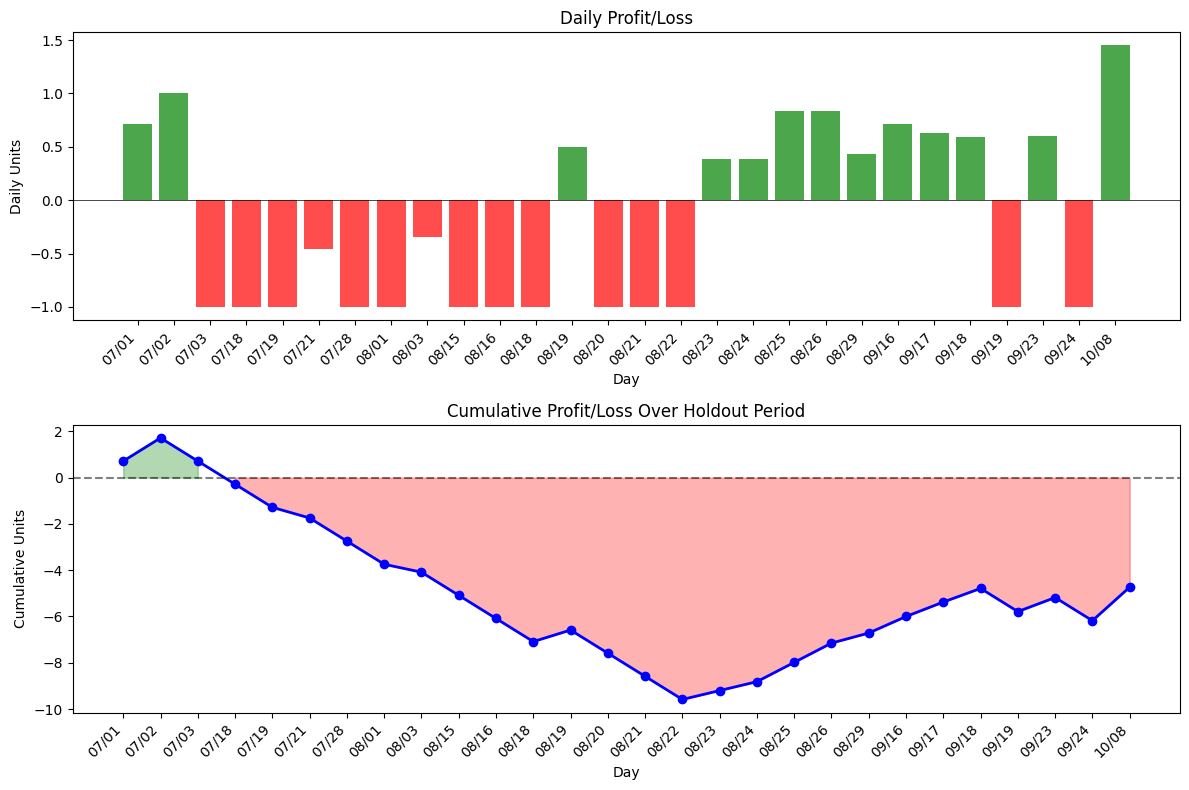


--- SUMMARY STATS ---
Days with bets: 28
Profitable days: 13
Losing days: 15
Break-even days: 0
Best day: +1.45 units
Worst day: -1.00 units
Avg bets per day: 1.1


In [13]:
# -----------------------------
# DAY-BY-DAY HOLDOUT ANALYSIS
# -----------------------------
import matplotlib.pyplot as plt

# Add gameDate to bets if not already there
bets_daily = bets.copy()
bets_daily['gameDate'] = holdout_test.loc[bets.index, 'gameDate'].values

# Group by date
daily_summary = bets_daily.groupby('gameDate').agg({
    'units': 'sum',
    'win': ['sum', 'count'],
    'bet_side': 'sum'  # Number of home bets
}).reset_index()

daily_summary.columns = ['gameDate', 'daily_units', 'wins', 'total_bets', 'home_bets']
daily_summary['losses'] = daily_summary['total_bets'] - daily_summary['wins']
daily_summary['away_bets'] = daily_summary['total_bets'] - daily_summary['home_bets']
daily_summary['cum_units'] = daily_summary['daily_units'].cumsum()
daily_summary['win_rate'] = daily_summary['wins'] / daily_summary['total_bets']

print("="*80)
print("DAY-BY-DAY BETTING LOG (Holdout Period: Sep-Nov 2025)")
print("="*80)
print(f"{'Date':<12} {'Bets':<6} {'W-L':<8} {'Daily':<10} {'Cumulative':<12} {'Sides'}")
print("-"*80)

for _, row in daily_summary.iterrows():
    date_str = row['gameDate'].strftime('%Y-%m-%d')
    wl = f"{int(row['wins'])}-{int(row['losses'])}"
    daily = f"{row['daily_units']:+.2f}"
    cum = f"{row['cum_units']:+.2f}"
    sides = f"H:{int(row['home_bets'])} A:{int(row['away_bets'])}"
    print(f"{date_str:<12} {int(row['total_bets']):<6} {wl:<8} {daily:<10} {cum:<12} {sides}")

print("-"*80)
print(f"{'TOTAL':<12} {daily_summary['total_bets'].sum():<6} "
      f"{int(daily_summary['wins'].sum())}-{int(daily_summary['losses'].sum()):<5} "
      f"{daily_summary['daily_units'].sum():+.2f}")

# Visualize daily performance
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Daily units
ax1 = axes[0]
colors = ['green' if u >= 0 else 'red' for u in daily_summary['daily_units']]
ax1.bar(range(len(daily_summary)), daily_summary['daily_units'], color=colors, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Day')
ax1.set_ylabel('Daily Units')
ax1.set_title('Daily Profit/Loss')
ax1.set_xticks(range(len(daily_summary)))
ax1.set_xticklabels([d.strftime('%m/%d') for d in daily_summary['gameDate']], rotation=45, ha='right')

# Plot 2: Cumulative units
ax2 = axes[1]
ax2.plot(range(len(daily_summary)), daily_summary['cum_units'], marker='o', linewidth=2, color='blue')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.fill_between(range(len(daily_summary)), 0, daily_summary['cum_units'], 
                  where=(daily_summary['cum_units'] >= 0), alpha=0.3, color='green')
ax2.fill_between(range(len(daily_summary)), 0, daily_summary['cum_units'], 
                  where=(daily_summary['cum_units'] < 0), alpha=0.3, color='red')
ax2.set_xlabel('Day')
ax2.set_ylabel('Cumulative Units')
ax2.set_title('Cumulative Profit/Loss Over Holdout Period')
ax2.set_xticks(range(len(daily_summary)))
ax2.set_xticklabels([d.strftime('%m/%d') for d in daily_summary['gameDate']], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Summary stats
print(f"\n--- SUMMARY STATS ---")
print(f"Days with bets: {len(daily_summary)}")
print(f"Profitable days: {(daily_summary['daily_units'] > 0).sum()}")
print(f"Losing days: {(daily_summary['daily_units'] < 0).sum()}")
print(f"Break-even days: {(daily_summary['daily_units'] == 0).sum()}")
print(f"Best day: {daily_summary['daily_units'].max():+.2f} units")
print(f"Worst day: {daily_summary['daily_units'].min():+.2f} units")
print(f"Avg bets per day: {daily_summary['total_bets'].mean():.1f}")